# Load dataset

In [36]:
from datasets import list_datasets
all_datasets = list_datasets()
print(len(all_datasets))
print(all_datasets[:10])

135127
['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [198]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [38]:
train_ds = emotions["train"]
test_ds = emotions["test"]
val_ds = emotions["validation"]
print(len(train_ds), train_ds[0])
print(train_ds.features)

16000 {'text': 'i didnt feel humiliated', 'label': 0}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [39]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df['label_name'] = df.apply(lambda x: train_ds.features['label'].int2str(x['label']), axis=1)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: >

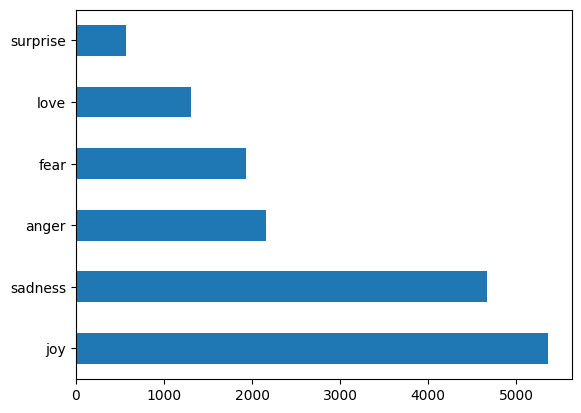

In [40]:
df['label_name'].value_counts().plot.barh()

<Axes: title={'center': 'token per tweet'}, xlabel='label_name'>

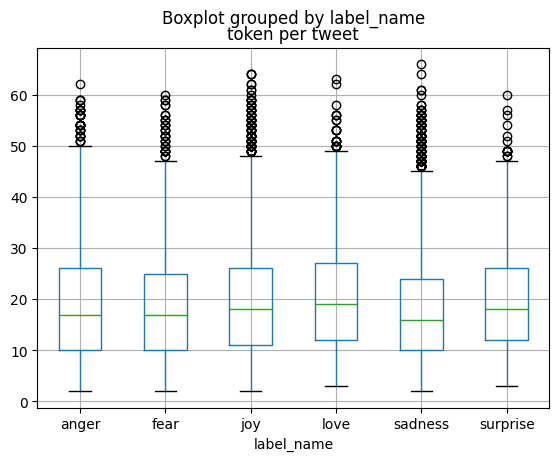

In [41]:
df['token per tweet'] = df['text'].str.split().apply(len)
df.boxplot('token per tweet', by='label_name')

# Tokenization

In [49]:
# subword tokenization
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
print(f"vocab size = {tokenizer.vocab_size}")

example_text = "Tokenizing text is an essential task in NLP. Let's get started."
encoded_text = tokenizer(example_text)
print(encoded_text)
print(tokenizer.convert_ids_to_tokens(encoded_text.input_ids))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_text.input_ids)))

vocab size = 30522
{'input_ids': [101, 19204, 6026, 3793, 2003, 2019, 6827, 4708, 1999, 17953, 2361, 1012, 2292, 1005, 1055, 2131, 2318, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'an', 'essential', 'task', 'in', 'nl', '##p', '.', 'let', "'", 's', 'get', 'started', '.', '[SEP]']
[CLS] tokenizing text is an essential task in nlp. let ' s get started. [SEP]


In [84]:
encoded_text.update({'label':1})

In [85]:
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 2019, 6827, 4708, 1999, 17953, 2361, 1012, 2292, 1005, 1055, 2131, 2318, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': 1}

In [90]:
def tokenize(batch):
    return tokenizer(list(batch["text"]), padding=True, truncation=True)
print(tokenize(train_ds[:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [91]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [107]:
for k in emotions_encoded:
    emotions_encoded[k] = emotions_encoded[k].add_column("label", list(emotions[k]["label"]))

# Model: data prep

In [64]:
import torch
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [66]:
text = "This is a test. NLP is great!"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 12])


In [67]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-5.9883e-04, -1.7338e-01,  2.9519e-02,  ..., -1.1462e-01,
           3.0177e-01,  4.5108e-01],
         [-2.1150e-01, -4.7318e-01, -2.8987e-02,  ..., -2.6335e-01,
           5.0803e-01,  4.0644e-01],
         [-1.5809e-01, -2.2234e-01,  1.3791e-01,  ...,  7.6267e-02,
           3.1981e-01,  8.4213e-01],
         ...,
         [ 4.1224e-01, -1.5811e-01,  1.8453e-01,  ..., -1.9711e-01,
           3.5727e-02,  2.3895e-02],
         [ 8.2687e-02, -1.8365e-01, -4.5916e-02,  ...,  1.0824e-01,
           3.5329e-01, -1.1933e-01],
         [ 9.3667e-01,  1.6186e-01, -3.3155e-01,  ...,  1.8813e-01,
          -3.7558e-01, -3.2283e-01]]]), hidden_states=None, attentions=None)


In [73]:
print(f"hidden state size = {outputs.last_hidden_state.size()}")
print(f"CLS token size = {outputs.last_hidden_state[:,0].size()}")

hidden state size = torch.Size([1, 12, 768])
CLS token size = torch.Size([1, 768])


In [74]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [111]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 2000
    })
})

In [113]:
def extract_hidden_states(batch):
    # batch inputs are token ids after tokenization"
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state
    return {"hidden_state": outputs[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.30 examples/s]


In [119]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_test = np.array(emotions_hidden["test"]["hidden_state"])
X_val = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_test = np.array(emotions_hidden["test"]["label"])
y_val = np.array(emotions_hidden["validation"]["label"])

In [120]:
X_val.shape

(2000, 768)

In [121]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_val, y_val)

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.633

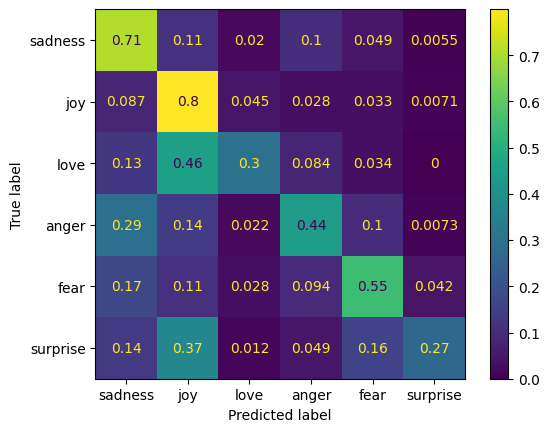

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_val_pred = lr_clf.predict(X_val)
p = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred, normalize="true"), display_labels=emotions['train'].features['label'].names)
p.plot()

# Fine-tuning

In [138]:
from transformers import AutoModelForSequenceClassification

In [139]:
n_labels = len(emotions['train'].features['label'].names)

In [140]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=n_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [141]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [150]:
from huggingface_hub import notebook_login

In [155]:
notebook_login()

In [156]:
from transformers import Trainer, TrainingArguments

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [157]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

In [186]:
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=2,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=True,
                                    log_level="error",
                                    use_mps_device=True)

In [160]:
trainer = Trainer(model=model, args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)

In [161]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.817300,0.326941,0.906500,0.905553
2,0.250200,0.211681,0.929000,0.928916


TrainOutput(global_step=500, training_loss=0.5337880859375, metrics={'train_runtime': 318.7735, 'train_samples_per_second': 100.385, 'train_steps_per_second': 1.569, 'total_flos': 720342861696000.0, 'train_loss': 0.5337880859375, 'epoch': 2.0})

In [164]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [165]:
preds_output.metrics

{'test_loss': 0.2116813361644745,
 'test_accuracy': 0.929,
 'test_f1': 0.9289159103142277,
 'test_runtime': 5.6608,
 'test_samples_per_second': 353.305,
 'test_steps_per_second': 5.653}

In [167]:
y_val_pred = np.argmax(preds_output.predictions, axis=1)

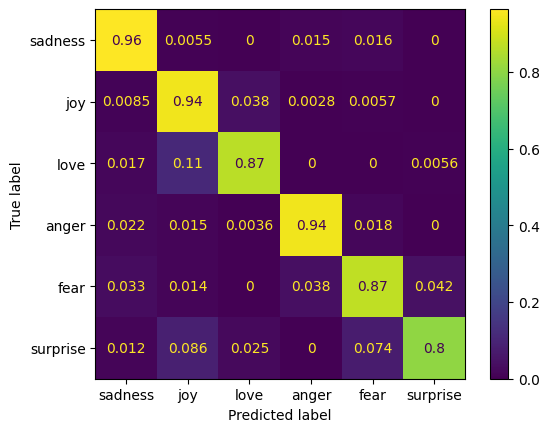

In [168]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred, normalize="true"), display_labels=emotions['train'].features['label'].names).plot()

# Error analysis

In [172]:
inputs

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1012, 17953,  2361,  2003,  2307,
            999,   102]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [188]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    device="mps"
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [189]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [190]:
emotions_encoded["validation"]

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 2000
})

In [197]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 352.04 examples/s]


In [205]:
emotions_encoded.set_format("pandas")
emotions.set_format("pandas")

In [219]:
df_val = pd.concat([emotions["validation"][:]['text'],emotions_encoded["validation"][:]], axis=1)[['text', 'label', 'loss', 'predicted_label']]

In [222]:
df_val['label_names'] = df_val['label'].apply(val_ds.features['label'].int2str)
df_val['predicted_label_names'] = df_val['predicted_label'].apply(val_ds.features['label'].int2str)

In [227]:
with pd.option_context('display.max_colwidth', None):
    display(df_val.sort_values("loss", ascending=False).head(10))

,text,label,loss,predicted_label,label_names,predicted_label_names
1801,i feel that he was being overshadowed by the supporting characters,2,5.401307,0,love,sadness
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,3,5.300870,0,anger,sadness
318,i felt ashamed of these feelings and was scared because i knew that something wrong with me and thought i might be gay,4,5.184979,0,fear,sadness
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,1,5.122453,0,joy,sadness
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,2,5.118984,0,love,sadness
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,1,4.923136,0,joy,sadness
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,5,4.775763,0,surprise,sadness
312,i like the domestic scene salty sweet combos recipe reviews the smell of rosemary babies the feeling of having exercised hand clapping rhymes books lost teacups and laundry that has been washed dried folded and put away,0,4.663596,1,sadness,joy
1683,i had applied for a job and they had assured me that the exams would take place a few months later a week later i went to obtain some more information and they told me that the exams had already taken place,3,4.650277,1,anger,joy
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,1,4.385153,4,joy,fear


In [228]:
with pd.option_context('display.max_colwidth', None):
    display(df_val.sort_values("loss", ascending=True).head(10))

,text,label,loss,predicted_label,label_names,predicted_label_names
632,i feel he is an terrific really worth bet,1,0.015824,1,joy,joy
669,i am not feeling very joyful today its been a rough day,1,0.015929,1,joy,joy
131,i feel like a graph doesnt show the data accurately enough to be useful,1,0.016096,1,joy,joy
578,i got to christmas feeling positive about the future and hopeful that hospital admissions were finally behind me,1,0.016183,1,joy,joy
1263,i feel this way about blake lively,1,0.016221,1,joy,joy
1418,i am a big believer in the phrase that some people are all style no substance and i feel that if you have nothing worthwhile to say just dont say it,1,0.016259,1,joy,joy
1513,i have also been getting back into my gym routine so im feeling positive about this now,1,0.016383,1,joy,joy
1523,i dont give a fuck because i feel like i cannot elicit any positive change or shifts within my current client load,1,0.016448,1,joy,joy
1368,i started this blog with pure intentions i must confess to starting to feel a little disheartened lately by the knowledge that there doesnt seem to be anybody reading it,0,0.016516,0,sadness,sadness
19,i had lunch with an old friend and it was nice but in general im not feeling energetic,1,0.016540,1,joy,joy


# save and share

In [229]:
trainer.push_to_hub(commit_message="Training completed!")

training_args.bin: 100%|██████████████████████████████████████████████████████████████████████████| 4.09k/4.09k [00:00<00:00, 8.88kB/s]


'https://huggingface.co/ryanjyc/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [230]:
from transformers import pipeline

model_id = "ryanjyc/distilbert-base-uncased-finetuned-emotion"
clf = pipeline("text-classification", model = model_id)

In [232]:
text = "I saw a movie today and it was very scary."
preds = clf(text, return_all_scores=True)

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


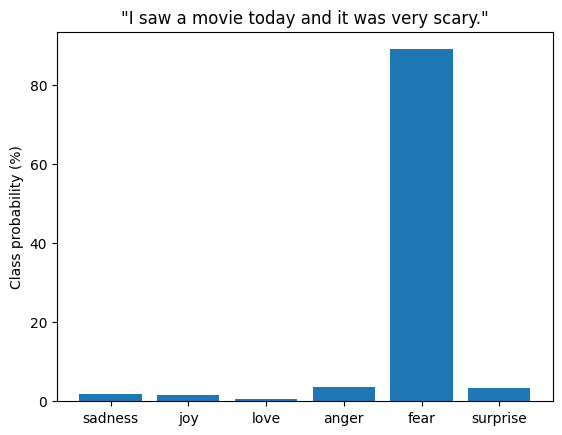

In [237]:
from matplotlib import pyplot as plt
labels = emotions['train'].features['label'].names

plt.bar(labels, 100 * pd.DataFrame(preds[0])["score"], color='C0')
plt.title(f'"{text}"')
plt.ylabel("Class probability (%)")
plt.show()